## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

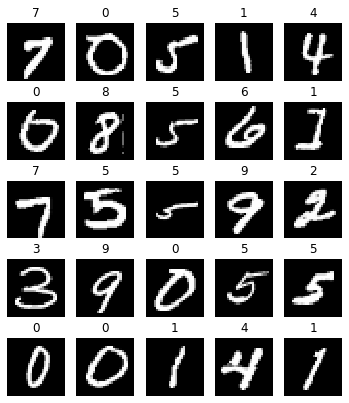

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [7]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [8]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

    
def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)

    
def He_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    d = 2 / weight.size()[0]
    weight.normal_(mean=0, std=np.sqrt(d))

In [13]:
def init_compare(init_f):
    net = []
    net.append(make_linear(28*28, 500, init_f))
    net.append(nn.ReLU())
    
    for i in range(4):
        net.append(make_linear(500, 500, init_f))
        net.append(nn.ReLU())
        
    net.append(make_linear(500, 10, init_f))
    net = nn.Sequential(*net)

    #пример:
    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = net(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

In [14]:
init_compare(xavier_init_uni)

forward 0.9701430797576904
forward 0.6320751309394836
forward 0.4573533236980438
forward 0.31916356086730957
forward 0.23631387948989868
forward 0.16544967889785767
backward 0.03711842745542526
backward 0.013488685712218285
backward 0.007793936412781477
backward 0.005033331457525492
backward 0.003011364722624421
backward 0.0017809972632676363


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [15]:
init_compare(xavier_init)

forward 0.9701430797576904
forward 0.6330148577690125
forward 0.44662779569625854
forward 0.3052002191543579
forward 0.21976791322231293
forward 0.15110734105110168
backward 0.03711842745542526
backward 0.012824086472392082
backward 0.008438391610980034
backward 0.005165462382137775
backward 0.0031257460359483957
backward 0.0018046549521386623


In [16]:
init_compare(He_init)

forward 0.9701430797576904
forward 1.015631079673767
forward 1.0249245166778564
forward 1.0024734735488892
forward 0.9931483864784241
forward 0.957338273525238
backward 0.03711842745542526
backward 0.09384962916374207
backward 0.08515066653490067
backward 0.07134313881397247
backward 0.05873655527830124
backward 0.05099547281861305


<i> 1.4 Сделайте выводы по первой части </i>

Метод инициализации Завьера (Xavier) (иногда — метод Glorot’а). Основная идея этого метода — упростить прохождение сигнала через слой во время как прямого, так и обратного распространения ошибки для линейной функции активации (этот метод также хорошо работает для сигмоидной функции, так как участок, где она ненасыщена, также имеет линейный характер).

Метод инициализации Ге (He) — это вариация метода Завьера, больше подходящая функции активации ReLU, компенсирующая тот факт, что эта функция возвращает нуль для половины области определения.

В таком случае, становится очевидным, почему инициализация Xavier на нашем примере сработала лучше чем He

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [17]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

    
    
class DropConnect(nn.Module):
    
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()        
        self.lin = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.ones_like(self.lin.weight) * self.p
        
        if self.training:
            mask = torch.ones_like(self.lin.weight) * self.p
            mask.bernoulli_()
            
        mask.detach_()
        output = torch.mm(x, (self.lin.weight*mask).transpose(0, 1))+self.lin.bias
        return output
    
    

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [18]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]): 
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.602/0.317	Accuracy: 0.850/0.924


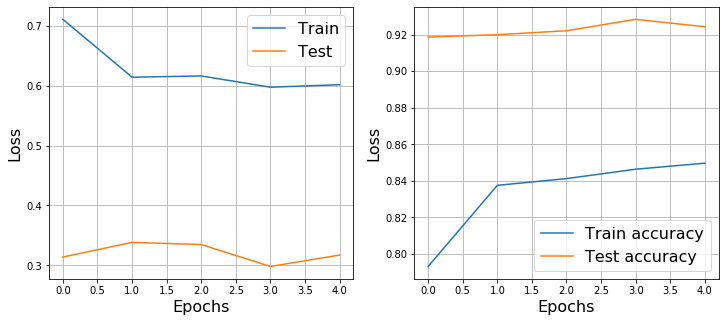

([0.7105281945866054,
  0.6140357743956641,
  0.6160933757895855,
  0.5973544437875117,
  0.601546626482437],
 [0.3140210384809518,
  0.3384856417586532,
  0.3348735283730151,
  0.2983305903175209,
  0.3173054939583887],
 [0.7931548, 0.8375478, 0.8412347, 0.8463764, 0.8496802],
 [0.9187105, 0.919996, 0.92217165, 0.9284019, 0.9243473])

In [19]:
train(net, train_loader, test_loader, 5, 0.01, device='cpu')

In [20]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]): 
    net.append(DropConnect(in_dim, out_dim, p=0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.256/0.144	Accuracy: 0.931/0.959


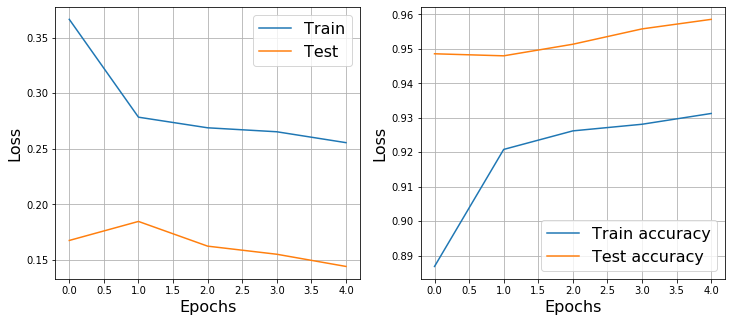

([0.3664196550782555,
  0.2784499545563767,
  0.2689091979043443,
  0.2653338786826205,
  0.2555488891947244],
 [0.16760815642302548,
  0.18470335487700715,
  0.16248571882142296,
  0.15519414375288576,
  0.14422998284991784],
 [0.88687146, 0.92082554, 0.92620605, 0.92812717, 0.93125886],
 [0.948576, 0.9479826, 0.9513449, 0.9557951, 0.9585641])

In [21]:
train(net, train_loader, test_loader, 5, 0.01, device='cpu')

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [75]:
class LayerNormalization(nn.Module):
    def __init__(self, dim, beta=0.07):
        super(LayerNormalization, self).__init__()  
        self.beta_mx = torch.zeros(dim) + beta
        self.flag = 1
        pass
        
    def forward(self, X):
        output = (X - X.mean(1).repeat(X.size()[1], 1).T) / (0.01 + X.std(1).repeat(X.size()[1], 1).T)
        output += self.beta_mx.repeat(X.shape[0]).view(X.shape[0], -1)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [80]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]): 
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.BatchNorm1d(num_features=out_dim))
    net.append(nn.ReLU())

net.append(nn.BatchNorm1d(num_features=sizes[-1]))
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))

net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.028/0.065	Accuracy: 0.991/0.981


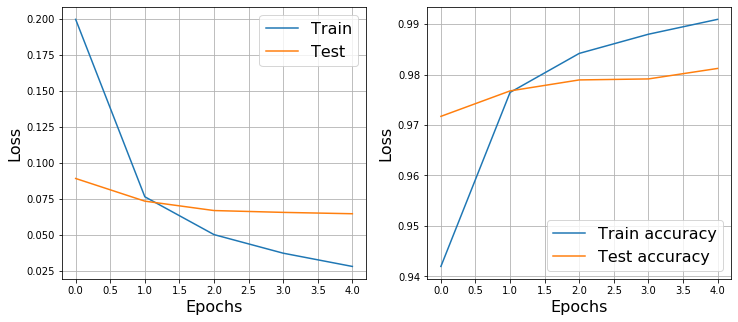

([0.1994651803401297,
  0.07646684106320206,
  0.05024395933223844,
  0.03736553800457131,
  0.028172991120629806],
 [0.08915344406438025,
  0.07343919645947745,
  0.06692265882451512,
  0.06565207128613433,
  0.06471109139744806],
 [0.9419754, 0.97646254, 0.9841918, 0.9879897, 0.9909382],
 [0.97171676, 0.97676027, 0.9789359, 0.9791337, 0.9812105])

In [81]:
train(net, train_loader, test_loader, 5, 0.0008, device='cpu')

In [76]:
net = [Flatten()]

sizes = [28**2, 200, 200]

for in_dim, out_dim in zip(sizes, sizes[1:]): 
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.ReLU())
    net.append(LayerNormalization(out_dim))
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))

net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.006/0.080	Accuracy: 0.998/0.982


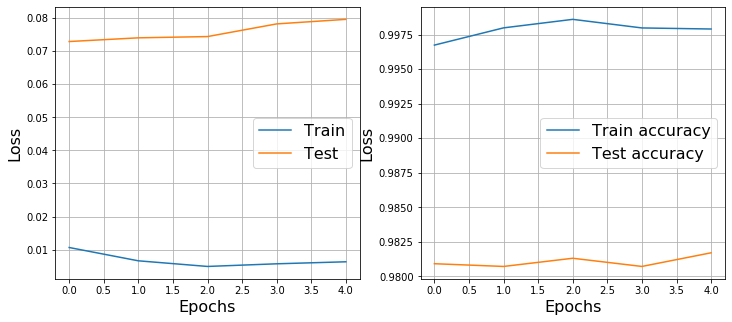

([0.01062970992128329,
  0.00660747901573385,
  0.004903087762018382,
  0.0057026810420583735,
  0.006310494595901298],
 [0.07290864207404607,
  0.07402923322117687,
  0.07440983742192576,
  0.07824133394576706,
  0.0796164994649707],
 [0.9967517, 0.99800104, 0.9986174, 0.99799556, 0.9979178],
 [0.98091376, 0.980716, 0.98130935, 0.980716, 0.9817049])

In [79]:
train(net, train_loader, test_loader, 5, 0.0008, device='cpu')

<i> 3.3 Сделайте выводы по третьей части </i>

Добавление слоёв LayerNormalization() и BatchNorm1d() позитивно сказывается на сходимости сетей
и приводит данные на тесте к виду более близкому к данным для обучения, чем увеличивает точность и 
снижает ошибку

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: